# Visualizing Gradient Descent in 3D

If you want to understand Machine Learning you have to understand gradient descent, at least this is what I have heard repeatedly on my first steps into the field. Taking the advice from my virtual teachers seriously, I have spent a considerable amont of time trying to get a solid and intuit understanding of gradient descent. Since I am a visual person, I tried to not only think through the concept, but also to visualize it.

This notebook is heavily based on [Jeremy Howard](https://jeremy.fast.ai/)'s  greate notebook "[How does a neural net really work?](https://www.kaggle.com/code/jhoward/how-does-a-neural-net-really-work/comments)", actually I borrowed quite a bit as you will see in comparison. The one thing, however, I was struggling with, was to truely visualize gradient descent in my mind. Sure, there is the analogy of a quadratic function, and you descent to the bottom, but this 2D-model is not what is happening in the example of fitting parameters for a quardatic $ax^2 + bx + c$, because you need to fit multiple paramters via gradient descent.

Since our human brains are limited to understanding 3D, I limited the original example to fitting the curve $ax^2 + bx$. $a$ and $b$ will be on the x- and y-axis and the loss will be plotted on the z-axis. 

Additionally, I have added elements of the great video "[The spelled-out intro to neural networks and backpropagation: building micrograd](https://www.youtube.com/watch?v=VMj-3S1tku0)" from [Andrej Karpathy](https://karpathy.ai/).

Before diving in, I have to say that I am deeply greatful for the material on the web to learn at my own pace. Since this notebook is not mainly about learning python (but on gradient descent), I will not explaint the details on how I created the visualizations, but I have put valuable links which helped me on the journey to write this notebook in the references section at the bottom.

## Here is our quadratic

Let's meet the specimen of this notebook: The simple quadratic function $3x^2 + 2x$:

In [2]:
from ipywidgets import interact
from fastai.basics import *

In [3]:
plt.rc('figure', dpi=90)

In [4]:
def plot_function(f, title=None, min=-2.1, max=2.1, color='r', ylim=None):
    x = torch.linspace(min,max, 100)[:,None]
    if ylim: plt.ylim(ylim)
    plt.plot(x, f(x), color)
    if title is not None: plt.title(title)

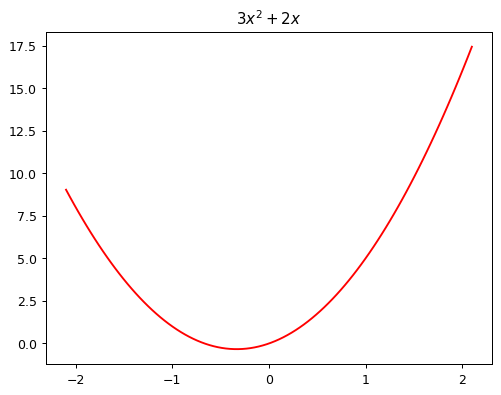

In [5]:
def f(x): return 3*x**2 + 2*x

plot_function(f, "$3x^2 + 2x$")

To get one thing out of the way: Finding the vertex / minimum point of this quadratic relates to gradient descent in the sense that this is about finding a minimum, but it is not the purpose of this notebook. Nontheless it is a nice warmup for what lies ahead:

Our quadratic's derivative is $6*x + 2$, therefore, the its vertex / minimum point is located at at $x = -1/3$.

We can also solve this interactively, by plotting the tangent $a*x + b$ representing the local derivative along the quaratic. The slope $a$ is the local derivative, and $b$ can be calculated as $f(x)-ax$: 

In [6]:
def line(a, b, x):
    return a*x + b

def mk_line (a, b):
    return partial(line, a,b)

def deriv(x):
    return 6*x + 2

@interact(x=(-2.0, 2.0, 0.01))
def plot_quad(x):
    
    #plot point
    plt.scatter(x, f(x), color='red');
    
    #plot tangent
    a = deriv(x)
    b = f(x) - a*x
    local_deriv = mk_line(a, b)
    plot_function(local_deriv, color='g')
    
    #plot quadratic
    plot_function(f)

interactive(children=(FloatSlider(value=0.0, description='x', max=2.0, min=-2.0, step=0.01), Output()), _dom_c…

**TODO**

To think about this as a gradient descent problem, we can plot the local derivative as a gradient (a vector as well)

Replace the tangent with a vector

## Manually fitting a quadratic function

The actual task we want to perform in this notebook is to bit a quadratic function to a set of points. So let's generate some points:

In [7]:
def noise(x, scale): return np.random.normal(scale=scale, size=x.shape)
def add_noise(x, mult, add): return x * (1+noise(x,mult)) + noise(x,add)

In [8]:
np.random.seed(42)

x = torch.linspace(-2, 2, steps=20)[:,None]
y = add_noise(f(x), 0.15, 1.5)

In [9]:
x[:5],y[:5]

(tensor([[-2.0000],
         [-1.7895],
         [-1.5789],
         [-1.3684],
         [-1.1579]]),
 tensor([[10.7945],
         [ 5.5640],
         [ 4.8425],
         [ 1.4019],
         [ 0.8299]], dtype=torch.float64))

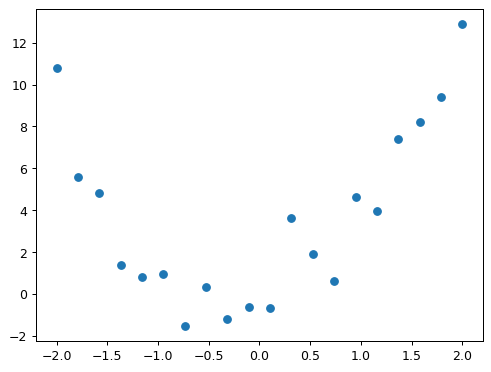

In [10]:
plt.scatter(x,y);

Assuming that these points can be fitted to a quadratic curve $ax^2 + bx$, we are now looking for the values $a$, $b$ which best match the points to the curve.

To do this, we need the we need the follow:

* We need to be able dynamically create a quadratic function with the parameters a and b
* When trying to fit the curve, you need to choose the parameters a and b so that they are closest to the curve. To measure how well our quadratic fits to the points we will use the mean absolute error (mea). This is also called the loss.

This is how we can dynamically define a quadratic function:

In [11]:
def quad(a, b, x): return a*x**2 + b*x
def mk_quad(a,b): return partial(quad, a,b)

Just to prove the point, let's re-plot $3x^2 + 2x$

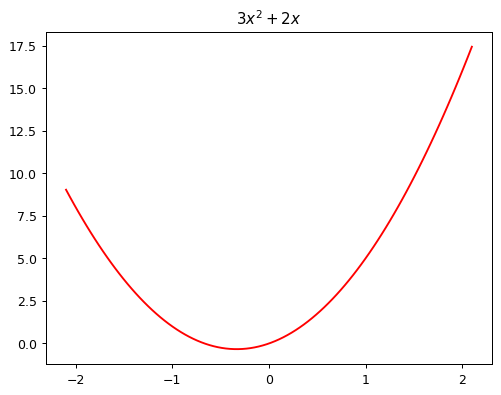

In [12]:
f2 = mk_quad(3,2)
plot_function(f2, "$3x^2 + 2x$")

This is how we can calculate the  mean absolute error (mae):

In [13]:
def mae(preds, acts): return (torch.abs(preds-acts)).mean()
def mae_np(preds, acts): return (np.abs(preds-acts)).mean() #numpy implementation used for 3D visualization 

Let's put it all together to interactively fit the curve:

In [14]:
@interact(a=(-4.0, 4.0, 0.01), b=(-4.0, 4.0, 0.01))
def plot_quad2(a, b):
    
    # plot points
    plt.scatter(x,y);
    
    f3 = mk_quad(a,b)
    
    mae_f3 = mae(f3(x), y)
    
    plot_function(f3, f"The current loss is {mae_f3:.4f}")

interactive(children=(FloatSlider(value=0.0, description='a', max=4.0, min=-4.0, step=0.01), FloatSlider(value…

When playing with the parameters, you are doing something like a manual gradient descent by moving the sliders in a way to minimize the loss.

While writing this, I stopped optimizing at a=2.45 and b=1.29 with a loss of 1.0528

But instead of try & error, how can we do this in a more systematical way?

As a first step, let's try to visualize the optimization process.

## Visualizing the loss function

By visualizing the loss function, we can see the minimum of the loss.

In our simple example, the loss is a function of a and b.

a and b will the on the x- and y-axis and, the loss will be on the z-axis.

In [15]:
import numpy as np
import matplotlib.pyplot as plt
import mpl_toolkits
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import pyplot

In [16]:
grid_x = np.linspace(0, 4, 50)
grid_y = np.linspace(0, 4, 50)

In [17]:
X, Y = np.meshgrid(grid_x, grid_y)

In [18]:
def loss(a, b):
    f = mk_quad(a,b)
    return mae_np(f(x), y)

In [19]:
Z = np.zeros((50, 50))

In [20]:
for x1 in range(len(X)):
    for y1 in range(len(Y)):
        Z[x1][y1] = loss(X[x1][y1], Y[x1][y1])

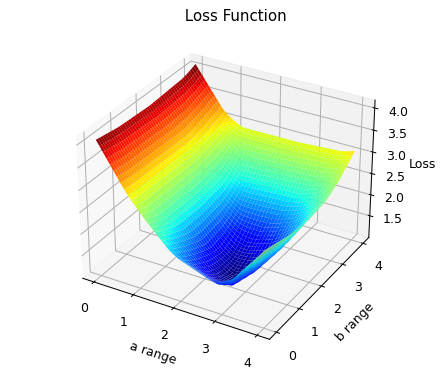

In [21]:
def plot_loss_3d():
    
    fig = plt.figure()
    ax = plt.axes(projection='3d')
    #spaces are a workarouf for the y-lable not being displayed correctly
    ax.set_title("                                     Loss Function                                ")
    ax.set_xlabel("a range")
    ax.set_ylabel("b range")
    ax.set_zlabel("Loss")
    ax.plot_surface(X, Y, Z, rstride=1, cstride=1,cmap='jet', edgecolor = 'none');
    
plot_loss_3d()

As we can see, the loss fucntion creates a 3-dimensional space, and we also recognize the minimum around the values that we tried interactively (see above: a=2.45 and b=1.29). These values are close, but not identical to the original funtion (a=3 and b=2) because the points are distributed randomly around the curve.

We can also make this plot interactive. Additionally, let's also plot the points and the function we are trying to fit:

In [22]:
@interact(a=(-4.0, 4.0, 0.01), b=(-4.0, 4.0, 0.01), azim=(0, 360, 1), elev=(-360, 360, 1))
def plot_loss_3d_and_quad(a,b, azim=290, elev=45):
        
    # Set up a figure twice as tall as it is wide
    fig = plt.figure(figsize=plt.figaspect(0.4))
    fig.suptitle('Interactive Function Fitting and the Loss in 3D')
        
    ax = fig.add_subplot(1, 2, 2, projection='3d')
    ax.set_title("                           Function Loss                                           ")
    ax.set_xlabel("a range")
    ax.set_ylabel("b range")
    ax.set_zlabel("Loss")
    ax.zaxis.label.set_rotation(87)
    
    #Loss function surface
    ax.plot_surface(X, Y, Z, rstride=1, cstride=1,cmap='jet', edgecolor = 'none', alpha = 0.5)
    
    #The current loss for a,b
    ax.scatter(a,b,loss(a,b), c='r') #changed color to red for readability
    
    ax.view_init(azim=azim, elev=elev)
    
    # Second chart
    ax = fig.add_subplot(1, 2, 1)
    
    #plot point
    plt.scatter(x,y);
    f3 = mk_quad(a,b)
    mae_f3 = mae(f3(x), y)
    plot_function(f3, f"The current loss is {mae_f3:.4f}")
                        
    plt.show();

interactive(children=(FloatSlider(value=0.0, description='a', max=4.0, min=-4.0, step=0.01), FloatSlider(value…

## Introducing gradients

So far we have visualized the problem, but how can we automate the problem?

We can somewhat intuit from the 3D-chart that we need to follow the gradients, i.e. the slope of our 3D-fuction at the point we are currently at.

Putting it a little differently: We need to find how the loss changes when we change a or b, i.e. the local derivative dLoss/da and dLoss/db.

Pytorch can help us calculating the gradients. Let's start at a=0 and b=0:


In [23]:
def quad_mae(params):
    f = mk_quad(*params)
    return mae(f(x), y)

In [24]:
ab = torch.tensor([0.0, 0.0])

In [25]:
ab.requires_grad_()

tensor([0., 0.], requires_grad=True)

In [26]:
auto_loss = quad_mae(ab)
auto_loss

tensor(4.0722, dtype=torch.float64, grad_fn=<MeanBackward0>)

So far the result looks familiar. Now we calculate the gradients:

In [27]:
auto_loss.backward()

In [28]:
ab.grad

tensor([-1.4072, -0.1053])

This means that the local derivative $dLoss/da$ is -1.4072 and that the local derivative $dLoss/da$ is -0.1053.

This means that the values $a=0$ and $b=0$ are a little to high because the negative derivative tell us that if we increase the a or b a little, the loss will go down. Remember, if a derivative in a point x is positive, the slope at this point is pointing upwards when looking in the direction of inceasing x. To visualize that, you can go back to the first interactive chart in which we depicted the derivative as a tangent to the quadratic.

Therefore, when solving our optimization of a and b, we need to nudge a and b in the opposite direction of the sign of the local derivative of $dLoss/da$ and $dLoss/da$.

If these derivatives do not really make sense to you, there are two options to dive deeper:

* Check out this fantastic video by Andrej Karpathy: <https://www.youtube.com/watch?v=VMj-3S1tku0&t=7850s>
* Let's visualize the gradients in 3D.



In [29]:
def plot_loss_3d_and_quad_and_gradient(a,b, azim=290, elev=45, grads=None, loss2visualize=None):
       
    # Set up a figure twice as tall as it is wide
    fig = plt.figure(figsize=plt.figaspect(0.4))
    fig.suptitle('Function Fitting and the Loss')
    
    
    ax = fig.add_subplot(1, 2, 2, projection='3d')
    #spaces are a workarouf for the y-lable not being displayed correctly
    ax.set_title("                           Function Loss                                           ")
    ax.set_xlabel(f"a={a:.4f}")
    ax.set_ylabel(f"b={b:.4f}")
    ax.set_zlabel("Loss")
    ax.zaxis.label.set_rotation(87)
    
    # Loss function surface
    ax.plot_surface(X, Y, Z, rstride=1, cstride=1,cmap='jet', edgecolor = 'none', alpha = 0.5)
    
    # The current loss for a,b
    if loss2visualize==None:
        current_loss=loss(a,b)
    else:
        current_loss=loss2visualize
    ax.scatter(a,b,current_loss, c='r') #changed color to red for readability
    
    ab = torch.tensor([a,b])
    if grads==None:
        # calculate the gradients
        ab.requires_grad_()
        loss_ab = quad_mae(ab)
        loss_ab.backward()
        ab.grad
    else:
        # use external gradients
        ab.grad = grads
    
    ax.set_title(f"Gradients: a: {ab.grad[0]:.4f}, b: {ab.grad[1]:.4f}")
    
    #visualize the gradients
    start = [a, b, current_loss]
    direction_a = [ab.grad[0]*-1, 0, 0]
    direction_b = [0, ab.grad[1]*-1, 0]
    ax.quiver(start[0], start[1], start[2], direction_a[0], direction_a[1], direction_a[2])
    ax.quiver(start[0], start[1], start[2], direction_b[0], direction_b[1], direction_b[2])
    ax.quiver(start[0], start[1], start[2], direction_a[0], direction_b[1], 0)
        
    ax.view_init(azim=azim, elev=elev)
    
    # Second chart
    ax = fig.add_subplot(1, 2, 1)
    #plot points
    plt.scatter(x,y);
    f3 = mk_quad(a,b)
    mae_f3 = mae(f3(x), y)
    plot_function(f3, f"The current loss is {mae_f3:.4f}")
                         
    plt.show();

In [30]:
@interact(a=(-4.0, 4.0, 0.01), b=(-4.0, 4.0, 0.01), azim=(0, 360, 1), elev=(-360, 360, 1))
def interactive_plot_loss_3d_and_quad_and_gradient(a,b, azim=290, elev=45):
    plot_loss_3d_and_quad_and_gradient(a,b, azim, elev)

interactive(children=(FloatSlider(value=0.0, description='a', max=4.0, min=-4.0, step=0.01), FloatSlider(value…

Following the direction of the gradients, it is easy to optimize: If the gradient is a above zero, decrease the parameter. If it is below zero, increase it.

We have a better result: a=2.52, b=1.36, Loss=1.0430

With the help of the gradients, we have become very good at manual gradient descent, so how do we automate it?

## Automating gradient descent

With all we have seen, we are now ready to code out optimizer, which consists of the following steps:

* We calculate the loss with the current parameters (e.g. a=0.0, b=0.0 at the beginning)
* We initialize the gradients, this is a step easily forgotten. The purpose is not to let the gradients add up. (For what happens when you do not have this line, please refer to the section below "What happens when we do not intitialize the gradients?")
* We calculate the gradients
* We update the paramters with the learning rate (More on the learning rate in the section below "What happens when we set the learning rate too high?")

In [31]:
def run_optimizer_step(params, lr=0.01, output=True):
    loss = quad_mae(params) # Forward pass
    params.grad = None #Initializing gradients (.zero_grad())
    loss.backward() #Calculate gradients
    with torch.no_grad(): params -= params.grad*lr #update parameters
    if output:
        print(f'step={i}; loss={loss:.2f}; a={ab[0]:.2f}; a_grad={ab.grad[0]:.2f}; b={ab[1]:.2f}; b_grad={ab.grad[1]:.2f}')
    loss_np = loss.detach().numpy()
    return loss_np

Let's re-initialize the parameters:

In [32]:
# Initializing
ab = torch.tensor([0.,0.])
ab.requires_grad_()

tensor([0., 0.], requires_grad=True)

Let's run the optimizer for 10 steps. (The learning rate of 0.4 is actually too high, but it produces a good result after 10 steps ;))

In [33]:
for i in range(10):
    run_optimizer_step(ab, lr=0.4)

step=0; loss=4.07; a=0.56; a_grad=-1.41; b=0.04; b_grad=-0.11
step=1; loss=3.28; a=1.13; a_grad=-1.41; b=0.08; b_grad=-0.11
step=2; loss=2.60; a=1.54; a_grad=-1.03; b=0.20; b_grad=-0.28
step=3; loss=2.17; a=1.90; a_grad=-0.91; b=0.37; b_grad=-0.43
step=4; loss=1.76; a=2.27; a_grad=-0.91; b=0.54; b_grad=-0.43
step=5; loss=1.43; a=2.51; a_grad=-0.59; b=0.79; b_grad=-0.61
step=6; loss=1.19; a=2.47; a_grad=0.08; b=0.96; b_grad=-0.42
step=7; loss=1.13; a=2.54; a_grad=-0.17; b=1.06; b_grad=-0.26
step=8; loss=1.10; a=2.61; a_grad=-0.17; b=1.17; b_grad=-0.26
step=9; loss=1.07; a=2.58; a_grad=0.08; b=1.21; b_grad=-0.11


We have a good result: The loss is 1.07 with a=2.58 and b=1.21

## Visualizung automatic gradient descent

If this was a bit too fast, let's run it again and visualize what happens along the way:

Run the follwoing cell once:

In [34]:
# Initializing
ab = torch.tensor([0.,0.])
ab.requires_grad_()
i = 0
loss_opt = 0.0

Run the following cell multiple times (and note that the initial state is not displayed, only the state after the optimization):

step=18; loss=1.08; a=2.61; a_grad=0.08; b=1.15; b_grad=-0.11


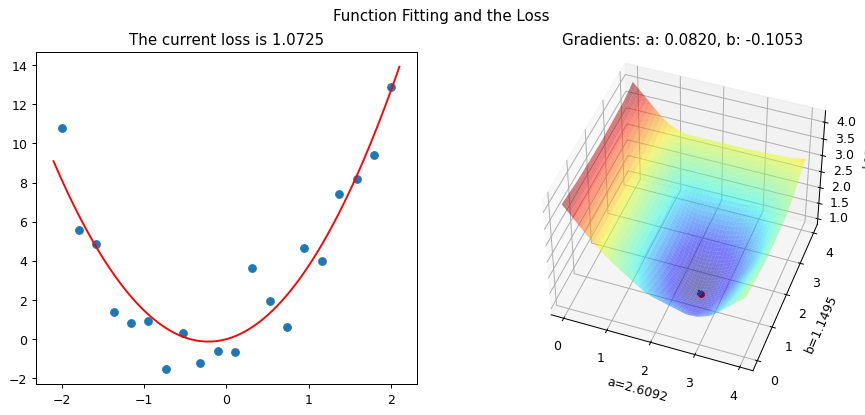

In [52]:
i += 1
loss_opt = run_optimizer_step(ab, lr=0.2)
plot_loss_3d_and_quad_and_gradient(a=float(ab[0]), b=float(ab[1]), grads=ab.grad, loss2visualize=loss_opt)

After running the cell above a couple of times, we arrive at the minimum.

You can play with the learning rate (`lr`) to see how the speed and the track of the optimization changes.

Somehow, this is the end: **We successfully visualized gradient descent!** :)

There are, however, a few additional visializations that I would like to share illustrate common questions or bugs in the code. 

## What happens when we set the learning rate too high?

A common question is: [How to we set the learning rate](https://www.youtube.com/watch?v=hBBOjCiFcuo&t=3383s)?

As Jeremy explained, the problem is that we will not find the optimum, but that we step too far and dance around the optimum.

We can see this when re-initializing and running the optimization with a learning rate of 1 (i.e. as if there were no learning rate):

In [53]:
# Initializing
ab = torch.tensor([0.,0.])
ab.requires_grad_()
for i in range(10):
    run_optimizer_step(ab, lr=1)

step=0; loss=4.07; a=1.41; a_grad=-1.41; b=0.11; b_grad=-0.11
step=1; loss=2.33; a=2.32; a_grad=-0.91; b=0.54; b_grad=-0.43
step=2; loss=1.41; a=2.67; a_grad=-0.34; b=1.31; b_grad=-0.77
step=3; loss=1.10; a=2.18; a_grad=0.48; b=1.21; b_grad=0.09
step=4; loss=1.23; a=3.08; a_grad=-0.90; b=1.38; b_grad=-0.17
step=5; loss=1.40; a=2.16; a_grad=0.92; b=1.31; b_grad=0.07
step=6; loss=1.23; a=3.06; a_grad=-0.90; b=1.47; b_grad=-0.17
step=7; loss=1.38; a=2.14; a_grad=0.92; b=1.40; b_grad=0.07
step=8; loss=1.23; a=3.04; a_grad=-0.90; b=1.57; b_grad=-0.17
step=9; loss=1.37; a=2.12; a_grad=0.92; b=1.49; b_grad=0.07


As a result we can see that the gradient for a keeps changing from about 0.9 to -0.9 and the gradient for b from 0.07 to -0.17.

We can also visualize this. Same as above, run the following cell once for initialization:

In [54]:
# Initializing
ab = torch.tensor([0.,0.])
ab.requires_grad_()
i = 0
loss_opt = 0.0

Run the following cell multiple times:

step=10; loss=1.37; a=2.12; a_grad=0.92; b=1.49; b_grad=0.07


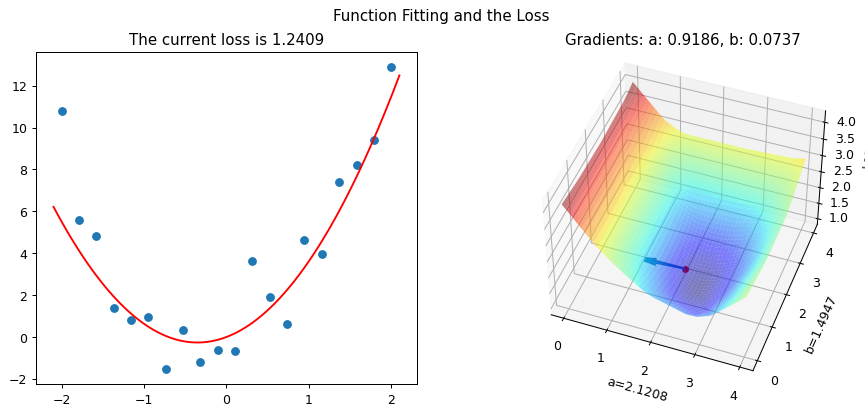

In [64]:
i += 1
loss_opt = run_optimizer_step(ab, lr=1)
plot_loss_3d_and_quad_and_gradient(a=float(ab[0]), b=float(ab[1]), grads=ab.grad, loss2visualize=loss_opt)

## What happens when we do not intitialize the gradients?

According to [Andrej Karpathy](https://twitter.com/karpathy/status/1013244313327681536?lang=en) one of the most common neural net mistakes is to forget to initialize the gradients, i.e. "_you forgot to .zero_grad() (in pytorch) before .backward()._"

This seems to be quite true, Andrej did this mistake in this own [video on gradient descent](https://www.youtube.com/watch?v=VMj-3S1tku0&t=7824s) - I thought that was hilarious and at the same time truely educational that he did not cut it out. Additionally, at the time of writing, the [template notebook (version 6)](https://www.kaggle.com/code/jhoward/how-does-a-neural-net-really-work) for this notebook also contained the bug.

Before discovering this, the visualization produced some strange results. Let me show you:

Here is the buggy optimizer:

In [65]:
def run_buggy_optimizer_step(params, lr=0.01, output=True):
    loss = quad_mae(params) # Forward pass
    #params.grad = None #Initializing gradients (.zero_grad())
    loss.backward() #Calculate gradients
    with torch.no_grad(): params -= params.grad*lr #update parameters
    if output:
        print(f'step={i}; loss={loss:.2f}; a={ab[0]:.2f}; a_grad={ab.grad[0]:.2f}; b={ab[1]:.2f}; b_grad={ab.grad[1]:.2f}')
    loss_np = loss.detach().numpy()
    return loss_np

Run this cell once (same as above):

In [66]:
# Initializing
ab = torch.tensor([0.,0.])
ab.requires_grad_()
i = 0
loss_opt = 0.0

Run the following cell multiple times (and note that the initial state is not displayed, only the state after the optimization):

step=12; loss=2.58; a=3.02; a_grad=4.12; b=3.50; b_grad=-1.58


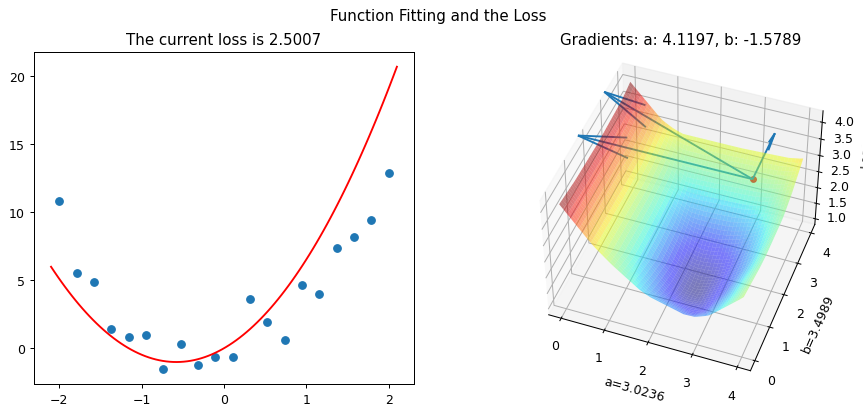

In [78]:
i += 1
loss_opt = run_buggy_optimizer_step(ab, lr=0.2)
plot_loss_3d_and_quad_and_gradient(a=float(ab[0]), b=float(ab[1]), grads=ab.grad, loss2visualize=loss_opt)

When you run the buggy optimizer for more than a steps, you will see that the parameters for a and b do not converge into the center. Instead they are swirling around in circles.

The reason for this is that the gradients get updated instead of being set to exactly the current local gradients.

More precisely: When calculating the gradients, they are added up by the chain rule from calculus (see Andrej's video for more details). Since we keep missing the target and overshoot, we get positive and negative gradients inte process and therefore the swirling movement.

For more Fast.AI content on this, you can also refer to [Chapter 4](https://github.com/fastai/fastbook/blob/master/04_mnist_basics.ipynb) of the book, section ("Step 5: Step the weights").

## Sources

[1] [Jeremy Howard](https://jeremy.fast.ai/)'s  great notebook "[How does a neural net really work?](https://www.kaggle.com/code/jhoward/how-does-a-neural-net-really-work/comments)"

[2] [The spelled-out intro to neural networks and backpropagation: building micrograd](https://www.youtube.com/watch?v=VMj-3S1tku0)" from [Andrej Karpathy](https://karpathy.ai/)

[3] [2D and 3D Axes in same Figure](https://matplotlib.org/stable/gallery/mplot3d/mixed_subplots.html)

[4] [Using Interact](https://ipywidgets.readthedocs.io/en/7.6.2/examples/Using%20Interact.html)

[5] [Python Pop: Plotting 3D Vectors](https://www.youtube.com/watch?v=c8Xb7krH2_w)

[6] [Professional 3D Plotting in Matplotlib](https://www.youtube.com/watch?v=fAztJg9oi7s)